In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pandas as pd
from pycaret.regression import *
import plotly.express as px

## IMPORT DATA
And do some simple processing

In [3]:
data = pd.read_csv('df_hourly.csv')
new_data = pd.read_csv('X_test_hourly.csv')

In [4]:
data.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,year,day_of_year,day_of_month,minute,day,building,pv_measurement,sun_zenith:d,sun_apparent_zenith:d,sun_equation_of_time
0,2019-01-01 00:00:00,5.6,1.240,1153.6,0.0,0.0,1153.6,1.0,275.2,0.0,...,2019,1,1,0,1,2,NaN,139.103522,139.103522,-3.195874
1,2019-01-01 00:00:00,5.6,1.239,1226.4,0.0,0.0,1226.4,0.0,275.4,0.0,...,2019,1,1,0,1,1,0.0,139.103522,139.103522,-3.195874
2,2019-01-01 01:00:00,5.3,1.241,1090.6,0.0,0.0,1090.6,1.0,274.5,0.0,...,2019,1,1,0,1,2,NaN,136.409500,136.409500,-3.215687
3,2019-01-01 01:00:00,5.4,1.241,1157.6,0.0,0.0,1157.6,0.0,274.7,0.0,...,2019,1,1,0,1,1,0.0,136.409500,136.409500,-3.215687
4,2019-01-01 02:00:00,5.5,1.238,1087.6,0.0,0.0,1087.6,0.0,275.0,0.0,...,2019,1,1,0,1,1,0.0,131.850365,131.850365,-3.235491


In [5]:
data.shape

(101290, 60)

In [8]:
new_data.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,hour,day_of_week,quarter,month,day_of_year,day_of_month,day,sun_zenith:d,sun_apparent_zenith:d,sun_equation_of_time
0,2023-05-01 00:00:00,4.4,1.286,912.7,0.0,0.0,1041.2,0.0,271.7,0.0,...,0,0,2,5,121,1,1,101.166019,101.166019,2.806174
1,2023-05-01 00:00:00,4.3,1.283,912.3,0.0,0.0,1039.9,0.0,271.7,0.0,...,0,0,2,5,121,1,1,101.166019,101.166019,2.806174
2,2023-05-01 00:00:00,4.2,1.286,NaN,0.0,0.0,1178.0,0.0,271.1,0.0,...,0,0,2,5,121,1,1,101.166019,101.166019,2.806174
3,2023-05-01 01:00:00,4.1,1.286,NaN,0.0,0.0,1334.1,0.0,270.9,0.0,...,1,0,2,5,121,1,1,99.059338,99.059338,2.811393
4,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.4,0.0,271.6,0.0,...,1,0,2,5,121,1,1,99.059338,99.059338,2.811393


In [9]:
new_data.shape

(2160, 55)

In [8]:
data_list = [data, new_data]

Need to remove special characters for light gradient lib

In [9]:
data["date_forecast"] = pd.to_datetime(data["date_forecast"])
data.columns = data.columns.str.replace(':', '_')
data.columns = data.columns.str.replace(' ', '_')

new_data["date_forecast"] = pd.to_datetime(new_data["date_forecast"])
new_data.columns = new_data.columns.str.replace(':', '_')
new_data.columns = new_data.columns.str.replace(' ', '_')

Removing features that doesn't make sense with the test data

1. 'minute' : Have sorted the dataframe on whole hours since pv_measurement is only per hour
2. 'snow_density_kgm3' : Missing from the test data
3. 'year' : Since we are trying to predict 30 days into 2023 year should not count

In [10]:
remove_features = ['minute', 'snow_density_kgm3', 'year']

In [11]:
for feature in remove_features:
    if feature in data.columns:
        data = data.drop(columns=[feature])
        
for feature in remove_features:
    if feature in new_data.columns:
        new_data = new_data.drop(columns=[feature])

Will also remove all entries to the dataframe where we don't have a pv_measurement

In [12]:
data_no_pv = data.dropna(subset=['pv_measurement'])

## Pycaret simulation setup

In [15]:
pycaret_setup = setup(data, target='pv_measurement', session_id=3, date_features=['date_forecast'], 
                      categorical_features=['elevation_m'], remove_outliers=True, feature_selection=True, log_experiment=True, 
                      experiment_name = 'letsgo_v2_not_norm')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7868
[LightGBM] [Info] Number of data points in the train set: 61811, number of used features: 58
[LightGBM] [Info] Start training from score 252.310611


,Description,Value
0,Session id,3
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(92951, 56)"
4,Transformed data shape,"(89697, 12)"
5,Transformed train set shape,"(61811, 12)"
6,Transformed test set shape,"(27886, 12)"
7,Numeric features,53
8,Date features,1
9,Categorical features,1


2023/10/19 12:12:41 INFO mlflow.tracking.fluent: Experiment with name 'letsgo_v2_not_norm' does not exist. Creating a new experiment.


In [22]:
X_train_transformed = get_config('X_train_transformed')

Train and compare the top 5 tree models

In [16]:
top5_tree_models = compare_models(include = ['dt', 'rf', 'et', 'gbr', 'xgboost', 'lightgbm', 'catboost'], sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,95.1956,77238.3815,277.7243,0.8687,1.0693,1.6852,9.9270
rf,Random Forest Regressor,96.1549,78466.9843,279.8084,0.8667,1.1183,1.5681,23.7450
lightgbm,Light Gradient Boosting Machine,96.6516,75238.0264,274.0567,0.8722,1.4481,2.5774,71.0140
catboost,CatBoost Regressor,97.1054,74285.7157,272.3271,0.8736,1.6556,3.7380,12.6150
xgboost,Extreme Gradient Boosting,101.0125,80263.2398,282.9492,0.8636,1.5029,3.0355,10.6960
gbr,Gradient Boosting Regressor,112.9362,88301.8406,296.9274,0.8500,1.9442,3.5323,9.2570
dt,Decision Tree Regressor,126.4297,154476.3039,392.6998,0.7375,1.1697,1.5532,4.1970


In [19]:
top5_tree_models

[ExtraTreesRegressor(n_jobs=-1, random_state=3),
 RandomForestRegressor(n_jobs=-1, random_state=3),
 LGBMRegressor(n_jobs=-1, random_state=3),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=3, ...)]

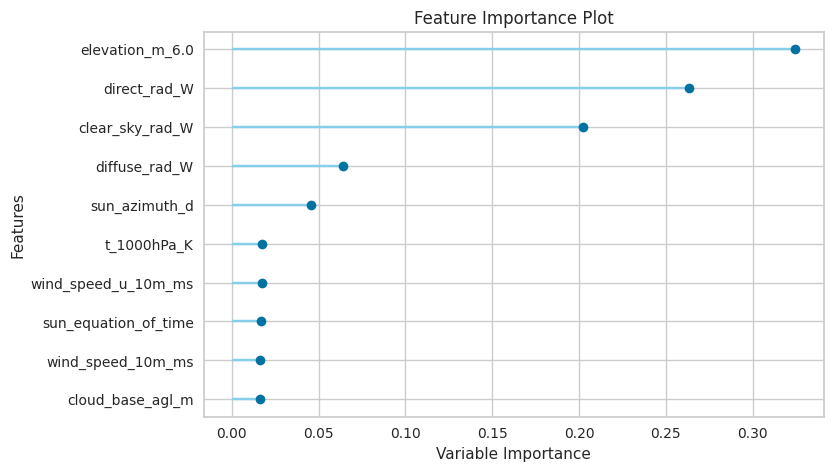

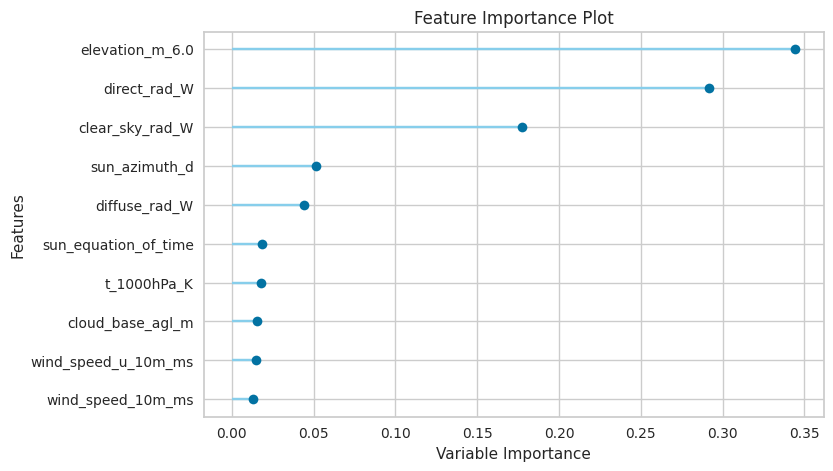

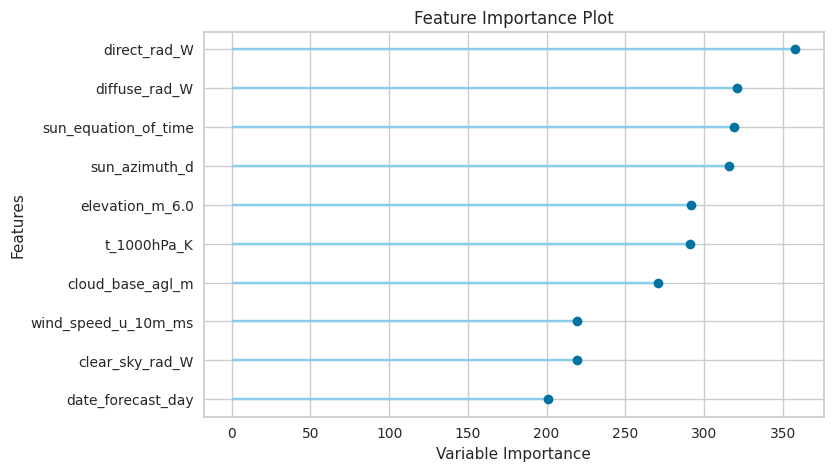

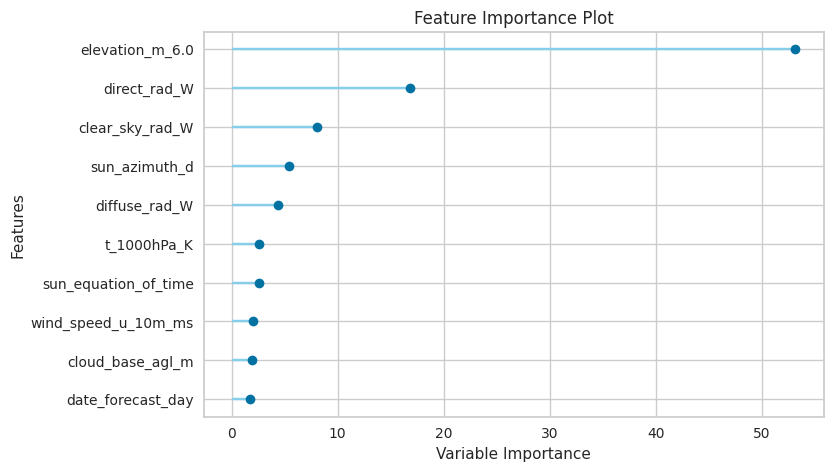

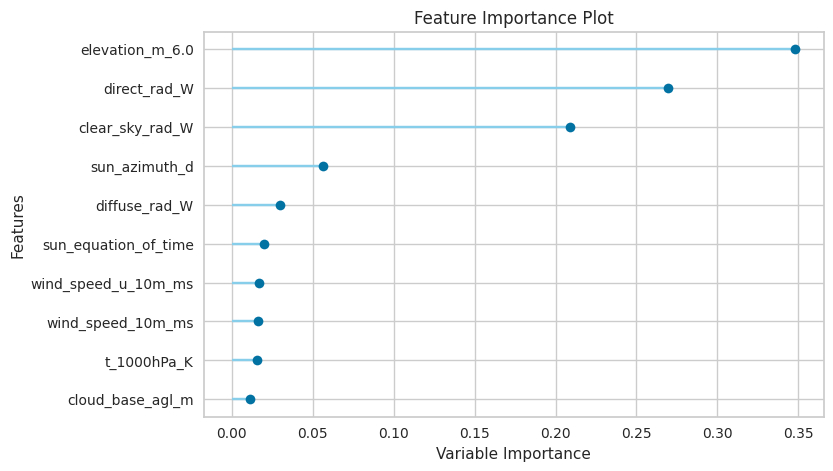

In [18]:
for model in top5_tree_models:
    plot_model(model, plot = 'feature')

In [30]:
ExtraTreesRegressor = top5_tree_models[0]
RandomForestRegressor = top5_tree_models[1]
LGBMRegressor = top5_tree_models[2]
CatBoostRegressor = top5_tree_models[3]
XGBRegressor = top5_tree_models[4]